In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, auc, confusion_matrix
import optuna

In [ ]:
train_df_full = pd.read_csv('../data/clean_data/train_clean.csv')
test_df = pd.read_csv('../data/clean_data/test_clean.csv')

In [29]:
base_features = [
    'amount_log', 
    'population_log',
    'amount_per_person',
    # 'lat', 'lon', 'merchant_lat', 'merchant_lon', 
    'txn_z_score_vs_user_cat', 'txn_delta_vs_user_cat_median',
    'txn_above_user_cat_p95', 'txn_distance_from_user_home_base'
]

mean_profile_features = [
    'user_profile_mean_cat_entertainment', 'user_profile_mean_cat_food_dining',
    'user_profile_mean_cat_gas_transport', 'user_profile_mean_cat_grocery_net',
    'user_profile_mean_cat_grocery_pos', 'user_profile_mean_cat_health_fitness',
    'user_profile_mean_cat_home', 'user_profile_mean_cat_kids_pets',
    'user_profile_mean_cat_misc_net', 'user_profile_mean_cat_misc_pos',
    'user_profile_mean_cat_personal_care', 'user_profile_mean_cat_shopping_net',
    'user_profile_mean_cat_shopping_pos', 'user_profile_mean_cat_travel'
]

geo_profile_features = [
    'user_profile_mean_geo_distance', 'user_profile_std_geo_distance',
    'user_profile_geo_unique_locations'
]

time_pattern_features_profile = ( 
    [f'user_profile_weekday_count_{i}' for i in range(7)] +
    [f'user_profile_hour_count_{i}' for i in range(24)]
)

other_profile_features = [
    'user_profile_mean_z_score', 'user_profile_frac_above_p95',
    'user_profile_std_z_score', 'user_profile_mean_delta_from_median',
    'user_profile_txn_count' 
]

model_features_config = (
    base_features +
    mean_profile_features +
    geo_profile_features +
    list(time_pattern_features_profile) + 
    other_profile_features
)

target_column = 'target'

all_model_features = [f for f in model_features_config if f in train_df_full.columns]
categorical_features_for_ohe = [f for f in ['cat_id', 'gender', 'is_night', 'hour', 'weekday'] if f in all_model_features]
numerical_features = [f for f in all_model_features if f not in categorical_features_for_ohe]


print(f"Всего отобрано признаков для модели: {len(all_model_features)}")
print(f"Категориальные для OHE: {categorical_features_for_ohe}")
print(f"Численные: {numerical_features}")

Всего отобрано признаков для модели: 60
Категориальные для OHE: []
Численные: ['amount_log', 'population_log', 'amount_per_person', 'txn_z_score_vs_user_cat', 'txn_delta_vs_user_cat_median', 'txn_above_user_cat_p95', 'txn_distance_from_user_home_base', 'user_profile_mean_cat_entertainment', 'user_profile_mean_cat_food_dining', 'user_profile_mean_cat_gas_transport', 'user_profile_mean_cat_grocery_net', 'user_profile_mean_cat_grocery_pos', 'user_profile_mean_cat_health_fitness', 'user_profile_mean_cat_home', 'user_profile_mean_cat_kids_pets', 'user_profile_mean_cat_misc_net', 'user_profile_mean_cat_misc_pos', 'user_profile_mean_cat_personal_care', 'user_profile_mean_cat_shopping_net', 'user_profile_mean_cat_shopping_pos', 'user_profile_mean_cat_travel', 'user_profile_mean_geo_distance', 'user_profile_std_geo_distance', 'user_profile_geo_unique_locations', 'user_profile_weekday_count_0', 'user_profile_weekday_count_1', 'user_profile_weekday_count_2', 'user_profile_weekday_count_3', 'user_

In [30]:
X_overall = train_df_full[all_model_features]
y_overall = train_df_full[target_column]
X_train_model, X_val_threshold, y_train_model, y_val_threshold = train_test_split(
    X_overall, y_overall, test_size=0.2, stratify=y_overall, random_state=42 
)

common_features_for_test = [f for f in all_model_features if f in test_df.columns]
X_test_final = test_df[common_features_for_test].copy()
y_test_final = test_df[target_column].copy()


print(f"Размер X_train_model: {X_train_model.shape}")
print(f"Размер X_val_threshold: {X_val_threshold.shape}")
print(f"Размер X_test_final: {X_test_final.shape}")

for col in numerical_features:
    if col in X_train_model.columns: 
        median_val = X_train_model[col].median()
        X_train_model[col] = X_train_model[col].fillna(median_val if pd.notnull(median_val) else 0)
        if col in X_val_threshold.columns:
            X_val_threshold[col] = X_val_threshold[col].fillna(median_val if pd.notnull(median_val) else 0)
        if col in X_test_final.columns:
            X_test_final[col] = X_test_final[col].fillna(median_val if pd.notnull(median_val) else 0)

if categorical_features_for_ohe:        
    for col in categorical_features_for_ohe:
        if col in X_train_model.columns:
            mode_val = X_train_model[col].mode()
            fill_val = mode_val[0] if not mode_val.empty else 'missing_value'
            X_train_model[col] = X_train_model[col].fillna(fill_val).astype(str)
            if col in X_val_threshold.columns:
                X_val_threshold[col] = X_val_threshold[col].fillna(fill_val).astype(str)
            if col in X_test_final.columns:
                X_test_final[col] = X_test_final[col].fillna(fill_val).astype(str)

print(f"\nПропуски в X_train_model после заполнения: {X_train_model.isnull().sum().sum()}")
print(f"Пропуски в X_val_threshold после заполнения: {X_val_threshold.isnull().sum().sum()}")
print(f"Пропуски в X_test_final после заполнения: {X_test_final.isnull().sum().sum()}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_for_ohe)
    ],
    remainder='drop' 
)

X_train_processed = preprocessor.fit_transform(X_train_model)
X_val_threshold_processed = preprocessor.transform(X_val_threshold)
X_test_final_processed = preprocessor.transform(X_test_final)

y_train_model_values = y_train_model.values
y_val_threshold_values = y_val_threshold.values
y_test_final_values = y_test_final.values

Размер X_train_model: (503315, 60)
Размер X_val_threshold: (125829, 60)
Размер X_test_final: (157287, 60)

Пропуски в X_train_model после заполнения: 0
Пропуски в X_val_threshold после заполнения: 0
Пропуски в X_test_final после заполнения: 0


In [31]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_model_values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_threshold_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_threshold_values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_final_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final_values, dtype=torch.float32).unsqueeze(1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor) 
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 1024 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

input_dim = X_train_tensor.shape[1] 
print(f"Размерность входных признаков для модели: {input_dim}")

Размерность входных признаков для модели: 60


In [32]:
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(FraudNet, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim1)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(dropout_rate)
        self.layer_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(dropout_rate)
        self.layer_3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu_3 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.relu_3(x)
        x = self.output_layer(x)
        return x

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch version: {torch.__version__}")

Using device: cpu


In [34]:
def objective_pytorch(trial):
    hidden_dim1 = trial.suggest_categorical('hidden_dim1', [64, 128, 256])
    hidden_dim2 = trial.suggest_categorical('hidden_dim2', [32, 64, 128])
    hidden_dim3 = trial.suggest_categorical('hidden_dim3', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay_opt = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    neg_count_train_model = np.sum(y_train_model_values == 0)
    pos_count_train_model = np.sum(y_train_model_values == 1)
    if pos_count_train_model > 0:
        calculated_pos_weight_val = neg_count_train_model / pos_count_train_model
    else:
        calculated_pos_weight_val = 1.0
    final_pos_weight_val = trial.suggest_float('pos_weight_final', 
                                           max(1.0, calculated_pos_weight_val * 0.5), 
                                           calculated_pos_weight_val * 2.0, 
                                           log=True)
    current_pos_weight = torch.tensor([final_pos_weight_val], dtype=torch.float32).to(device)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=trial.number)
    f1_scores_cv = []

    for fold, (train_idx_cv, val_idx_cv) in enumerate(cv.split(X_train_tensor, y_train_tensor)):
        X_cv_train = X_train_tensor[train_idx_cv]
        y_cv_train = y_train_tensor[train_idx_cv]
        X_cv_val = X_train_tensor[val_idx_cv]
        y_cv_val = y_train_tensor[val_idx_cv]

        cv_train_dataset = TensorDataset(X_cv_train, y_cv_train)
        cv_val_dataset = TensorDataset(X_cv_val, y_cv_val) 
        
        cv_train_loader = DataLoader(cv_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        cv_val_loader_metric = DataLoader(cv_val_dataset, batch_size=BATCH_SIZE, shuffle=False)


        model_cv = FraudNet(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate).to(device)
        criterion_cv = nn.BCEWithLogitsLoss(pos_weight=current_pos_weight)
        optimizer_cv = optim.Adam(model_cv.parameters(), lr=lr, weight_decay=weight_decay_opt)
        
        N_EPOCHS_OPTUNA = 15 
        for epoch_cv in range(N_EPOCHS_OPTUNA):
            model_cv.train()
            for data_cv, target_cv in cv_train_loader:
                data_cv, target_cv = data_cv.to(device), target_cv.to(device)
                optimizer_cv.zero_grad()
                outputs_cv = model_cv(data_cv)
                loss_cv = criterion_cv(outputs_cv, target_cv)
                loss_cv.backward()
                optimizer_cv.step()
        
        model_cv.eval()
        fold_val_targets = []
        fold_val_probas = []
        with torch.no_grad():
            for data_cv_val, target_cv_val in cv_val_loader_metric:
                data_cv_val = data_cv_val.to(device)
                logits_cv_val = model_cv(data_cv_val)
                proba_cv_val = torch.sigmoid(logits_cv_val)
                fold_val_targets.extend(target_cv_val.cpu().numpy().flatten())
                fold_val_probas.extend(proba_cv_val.cpu().numpy().flatten())
        
        fold_val_targets = np.array(fold_val_targets)
        fold_val_probas = np.array(fold_val_probas)
        
        thresholds_optuna_cv = np.arange(0.1, 0.9, 0.1) 
        best_f1_fold_cv = 0
        for t_cv_opt in thresholds_optuna_cv:
            labels_cv_opt = (fold_val_probas >= t_cv_opt).astype(int)
            current_f1_cv_opt = f1_score(fold_val_targets, labels_cv_opt, zero_division=0)
            if current_f1_cv_opt > best_f1_fold_cv:
                best_f1_fold_cv = current_f1_cv_opt
        f1_scores_cv.append(best_f1_fold_cv)
        
    return np.mean(f1_scores_cv)

In [35]:
print("Начинаем подбор гиперпараметров PyTorch модели с Optuna...")
study_pytorch = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_pytorch.optimize(objective_pytorch, n_trials=20, timeout=3600) 

best_pytorch_params = study_pytorch.best_params
print("\nЛучшие гиперпараметры для PyTorch:")
print(best_pytorch_params)
print(f"\nИспользуются параметры для PyTorch (дефолтные/из примера): {best_pytorch_params}")

[I 2025-05-11 22:33:14,645] A new study created in memory with name: no-name-b9042739-ee09-4452-a44d-3bb7feeb68cf


Начинаем подбор гиперпараметров PyTorch модели с Optuna...


[I 2025-05-11 22:34:35,776] Trial 0 finished with value: 0.3542447320837215 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'hidden_dim3': 32, 'dropout_rate': 0.3832290311184182, 'lr': 0.00010994335574766199, 'weight_decay': 0.0008123245085588687, 'pos_weight_final': 270.5758266960247}. Best is trial 0 with value: 0.3542447320837215.
[I 2025-05-11 22:35:49,886] Trial 1 finished with value: 0.3565753429844692 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 64, 'hidden_dim3': 32, 'dropout_rate': 0.21685785941408728, 'lr': 0.0005404103854647331, 'weight_decay': 2.334586407601622e-05, 'pos_weight_final': 253.41459131588434}. Best is trial 1 with value: 0.3565753429844692.
[I 2025-05-11 22:37:25,542] Trial 2 finished with value: 0.4121595753879486 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'hidden_dim3': 64, 'dropout_rate': 0.42335893924658446, 'lr': 0.0004066563313514797, 'weight_decay': 1.9634341572933316e-06, 'pos_weight_final': 220.32202518524602}. Best is trial 


Лучшие гиперпараметры для PyTorch:
{'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 32, 'dropout_rate': 0.4604102786540141, 'lr': 0.006191738052323996, 'weight_decay': 4.773618185168047e-05, 'pos_weight_final': 86.90469958509001}

Используются параметры для PyTorch (дефолтные/из примера): {'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 32, 'dropout_rate': 0.4604102786540141, 'lr': 0.006191738052323996, 'weight_decay': 4.773618185168047e-05, 'pos_weight_final': 86.90469958509001}


In [37]:
print("\nОбучение финальной PyTorch модели...")

final_pytorch_model = FraudNet(
    input_dim,
    hidden_dim1=best_pytorch_params.get('hidden_dim1', 128),
    hidden_dim2=best_pytorch_params.get('hidden_dim2', 64),
    hidden_dim3=best_pytorch_params.get('hidden_dim3', 32),
    dropout_rate=best_pytorch_params.get('dropout_rate', 0.3)
).to(device)

current_pos_weight_final = torch.tensor([best_pytorch_params.get('pos_weight_final', 170.0)], dtype=torch.float32).to(device)
criterion_final = nn.BCEWithLogitsLoss(pos_weight=current_pos_weight_final)
optimizer_final = optim.Adam(
    final_pytorch_model.parameters(), 
    lr=best_pytorch_params.get('lr', 0.001), 
    weight_decay=best_pytorch_params.get('weight_decay', 1e-5)
)
scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(optimizer_final, 'max', patience=5, factor=0.5) 

N_EPOCHS_FINAL = 100 
best_val_f1_final = -1.0
patience_early_stopping = 10
patience_counter_final = 0

train_losses = []
val_losses = []
val_f1s = []

for epoch in range(N_EPOCHS_FINAL):
    final_pytorch_model.train()
    epoch_train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_final.zero_grad()
        outputs = final_pytorch_model(data)
        loss = criterion_final(outputs, target)
        loss.backward()
        optimizer_final.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    final_pytorch_model.eval()
    epoch_val_loss = 0.0
    all_val_targets_epoch = []
    all_val_outputs_epoch_proba = []
    with torch.no_grad():
        for data_val, target_val in val_loader: 
            data_val, target_val = data_val.to(device), target_val.to(device)
            logits_val = final_pytorch_model(data_val)
            loss_val_batch = criterion_final(logits_val, target_val)
            epoch_val_loss += loss_val_batch.item()
            proba_val = torch.sigmoid(logits_val)
            all_val_targets_epoch.extend(target_val.cpu().numpy().flatten())
            all_val_outputs_epoch_proba.extend(proba_val.cpu().numpy().flatten())
    
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    all_val_targets_epoch_arr = np.array(all_val_targets_epoch)
    all_val_outputs_epoch_proba_arr = np.array(all_val_outputs_epoch_proba)
    
    val_preds_labels_epoch = (all_val_outputs_epoch_proba_arr > 0.5).astype(int) 
    val_f1_epoch = f1_score(all_val_targets_epoch_arr, val_preds_labels_epoch, zero_division=0)
    val_f1s.append(val_f1_epoch)
    
    scheduler_final.step(val_f1_epoch) 
    
    print(f'Epoch {epoch+1}/{N_EPOCHS_FINAL}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val F1 (p=0.5): {val_f1_epoch:.4f}')

    if val_f1_epoch > best_val_f1_final:
        best_val_f1_final = val_f1_epoch
        patience_counter_final = 0
        torch.save(final_pytorch_model.state_dict(), 'best_pytorch_fraud_model.pth')
        print(f"Epoch {epoch+1}: Val F1 улучшился до {best_val_f1_final:.4f}, модель сохранена.")
    else:
        patience_counter_final += 1
    
    if patience_counter_final >= patience_early_stopping:
        print(f"Early stopping сработало на эпохе {epoch+1}")
        break


Обучение финальной PyTorch модели...
Epoch 1/100: Train Loss: 0.5064, Val Loss: 0.3654, Val F1 (p=0.5): 0.3004
Epoch 1: Val F1 улучшился до 0.3004, модель сохранена.
Epoch 2/100: Train Loss: 0.3897, Val Loss: 0.3235, Val F1 (p=0.5): 0.3321
Epoch 2: Val F1 улучшился до 0.3321, модель сохранена.
Epoch 3/100: Train Loss: 0.3577, Val Loss: 0.2943, Val F1 (p=0.5): 0.3754
Epoch 3: Val F1 улучшился до 0.3754, модель сохранена.
Epoch 4/100: Train Loss: 0.3437, Val Loss: 0.2908, Val F1 (p=0.5): 0.4683
Epoch 4: Val F1 улучшился до 0.4683, модель сохранена.
Epoch 5/100: Train Loss: 0.3238, Val Loss: 0.2920, Val F1 (p=0.5): 0.4589
Epoch 6/100: Train Loss: 0.3226, Val Loss: 0.2912, Val F1 (p=0.5): 0.4610
Epoch 7/100: Train Loss: 0.3077, Val Loss: 0.2975, Val F1 (p=0.5): 0.4890
Epoch 7: Val F1 улучшился до 0.4890, модель сохранена.
Epoch 8/100: Train Loss: 0.3143, Val Loss: 0.2758, Val F1 (p=0.5): 0.4200
Epoch 9/100: Train Loss: 0.2980, Val Loss: 0.2675, Val F1 (p=0.5): 0.4117
Epoch 10/100: Train L


Подбор оптимального порога для PyTorch модели на валидационном наборе...
Оптимальный порог для PyTorch F1 на валидационном наборе: 0.8900
Максимальный PyTorch F1 на валидационном наборе: 0.7093


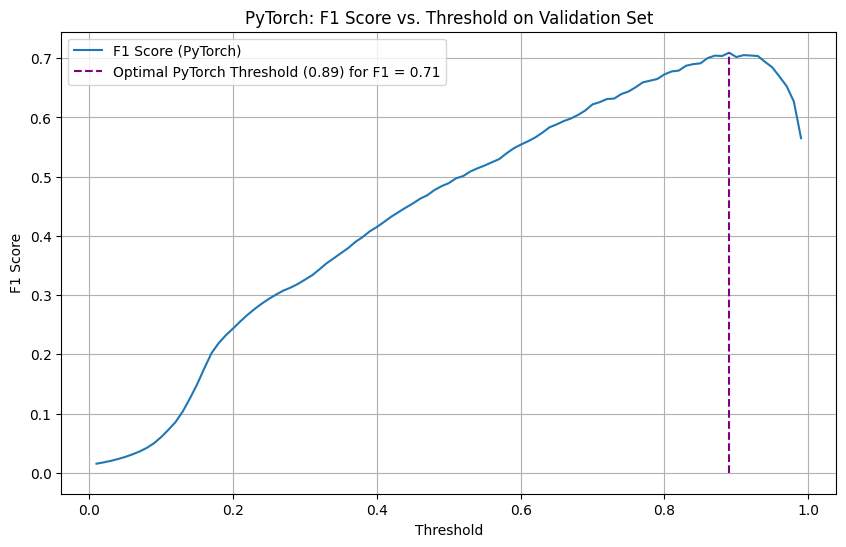

In [38]:
print("\nПодбор оптимального порога для PyTorch модели на валидационном наборе...")
val_preds_proba_for_thresh_pt_list = []
final_pytorch_model.eval()
with torch.no_grad():
    for data_v, _ in val_loader: 
        data_v = data_v.to(device)
        logits_v = final_pytorch_model(data_v)
        proba_v = torch.sigmoid(logits_v)
        val_preds_proba_for_thresh_pt_list.extend(proba_v.cpu().numpy().flatten())

val_preds_proba_for_thresh_pt = np.array(val_preds_proba_for_thresh_pt_list)
y_val_actual_for_thresh_pt = y_val_threshold.values 

thresholds_pt_range = np.arange(0.01, 1.0, 0.01)
f1_values_thresh_pt = []

for thresh_val_pt in thresholds_pt_range:
    preds_labels_thresh_pt = (val_preds_proba_for_thresh_pt >= thresh_val_pt).astype(int)
    f1_values_thresh_pt.append(f1_score(y_val_actual_for_thresh_pt, preds_labels_thresh_pt, zero_division=0))

if f1_values_thresh_pt:
    best_f1_idx_thresh_pt = np.argmax(f1_values_thresh_pt)
    optimal_threshold_pytorch = thresholds_pt_range[best_f1_idx_thresh_pt]
    max_f1_on_val_pytorch = f1_values_thresh_pt[best_f1_idx_thresh_pt]

    print(f"Оптимальный порог для PyTorch F1 на валидационном наборе: {optimal_threshold_pytorch:.4f}")
    print(f"Максимальный PyTorch F1 на валидационном наборе: {max_f1_on_val_pytorch:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_pt_range, f1_values_thresh_pt, label="F1 Score (PyTorch)")
    plt.vlines(optimal_threshold_pytorch, 0, max_f1_on_val_pytorch, color='purple', linestyle='--', 
               label=f'Optimal PyTorch Threshold ({optimal_threshold_pytorch:.2f}) for F1 = {max_f1_on_val_pytorch:.2f}')
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("PyTorch: F1 Score vs. Threshold on Validation Set")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Не удалось рассчитать F1 для подбора порога PyTorch. Используем порог 0.5.")
    optimal_threshold_pytorch = 0.5


--- Финальный отчет по PyTorch модели на тестовых данных с порогом 0.8900 ---
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00    156448
    Fraud (1)       0.42      0.60      0.49       839

     accuracy                           0.99    157287
    macro avg       0.71      0.80      0.75    157287
 weighted avg       0.99      0.99      0.99    157287

PyTorch ROC AUC на тесте: 0.9588
PyTorch F1-score на тесте (с оптимальным порогом 0.89): 0.4946
PyTorch Precision-Recall AUC на тесте: 0.4217

PyTorch Матрица ошибок на тесте (с оптимальным порогом):
[[155765    683]
 [   339    500]]


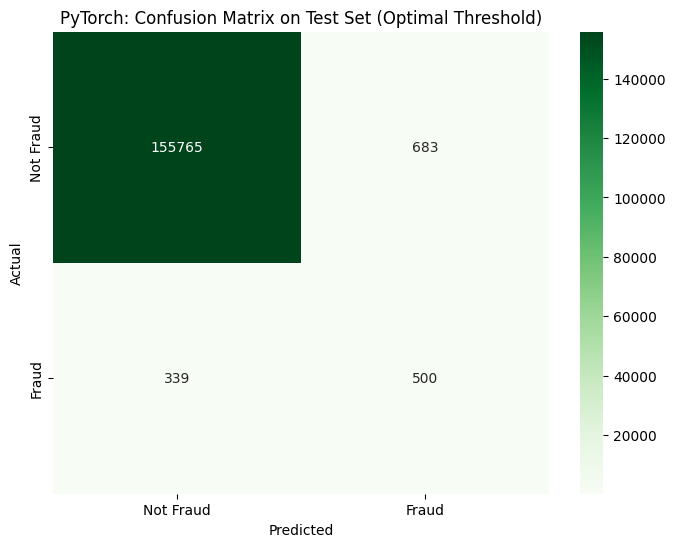

In [39]:
print(f"\n--- Финальный отчет по PyTorch модели на тестовых данных с порогом {optimal_threshold_pytorch:.4f} ---")
test_preds_proba_final_pt_list = []
final_pytorch_model.eval()
with torch.no_grad():
    for data_f_pt, _ in test_loader: 
        data_f_pt = data_f_pt.to(device)
        logits_f_pt = final_pytorch_model(data_f_pt)
        proba_f_pt = torch.sigmoid(logits_f_pt)
        test_preds_proba_final_pt_list.extend(proba_f_pt.cpu().numpy().flatten())

test_preds_proba_final_pt = np.array(test_preds_proba_final_pt_list)
test_preds_labels_final_optimal_pt = (test_preds_proba_final_pt >= optimal_threshold_pytorch).astype(int)

y_test_final_eval_pt = y_test_final.values 

roc_auc_test_pt = roc_auc_score(y_test_final_eval_pt, test_preds_proba_final_pt)
f1_test_optimal_pt = f1_score(y_test_final_eval_pt, test_preds_labels_final_optimal_pt, zero_division=0)
precision_test_vals_pt, recall_test_vals_pt, _ = precision_recall_curve(y_test_final_eval_pt, test_preds_proba_final_pt)
pr_auc_test_pt = auc(recall_test_vals_pt, precision_test_vals_pt)

print(classification_report(y_test_final_eval_pt, test_preds_labels_final_optimal_pt, target_names=['Not Fraud (0)', 'Fraud (1)'], zero_division=0))
print(f"PyTorch ROC AUC на тесте: {roc_auc_test_pt:.4f}")
print(f"PyTorch F1-score на тесте (с оптимальным порогом {optimal_threshold_pytorch:.2f}): {f1_test_optimal_pt:.4f}")
print(f"PyTorch Precision-Recall AUC на тесте: {pr_auc_test_pt:.4f}")

print("\nPyTorch Матрица ошибок на тесте (с оптимальным порогом):")
cm_pt = confusion_matrix(y_test_final_eval_pt, test_preds_labels_final_optimal_pt)
print(cm_pt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('PyTorch: Confusion Matrix on Test Set (Optimal Threshold)')
plt.show()